Train 16-split classifier on pretrained encoder (pretrained on reconstruction). Here we use only model 1 from E32, because of the worse classification results for model 2.

In [1]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, nrows, ncols):
    ndata = np.zeros((len(data), nrows, ncols, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(ncols-width)
        y = np.random.randint(nrows-height)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
io_shape = (56,56,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16 * 4 # since we have 4x4-splits we need 4 times the latent space for a fair comparison.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, _ = embed_and_translate(x_train, 56, 56)
x_train_split = np.array([utils.split(x, size, size) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, _ = embed_and_translate(x_test, 56, 56)
x_test_split = np.array([utils.split(x, size, size) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

After pretraining much worse classification results. Accuracy of ~78%

In [2]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
#         y_pred = self.decode(z ,training=training)
        y_pred = self.classify(z ,training=training)
#         y_pred = self.regress(z ,training=training)
        return y_pred
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax')
        ])

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 1.9641 - acc: 0.2853 - val_loss: 1.6892 - val_acc: 0.4018
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1.5274 - acc: 0.4561 - val_loss: 1.3921 - val_acc: 0.5056
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1.3265 - acc: 0.5297 - val_loss: 1.3295 - val_acc: 0.5251
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1.2139 - acc: 0.5714 - val_loss: 1.1572 - val_acc: 0.5904
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1345 - acc: 0.5983 - val_loss: 1.1165 - val_acc: 0.6093
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0725 - acc: 0.6208 - val_loss: 1.0494 - val_acc: 0.6283
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0224 - acc: 0.6379 - val_loss: 1.0140 - val_acc: 0.6392
Epoch 8/100
1875/1875 [==============================] 

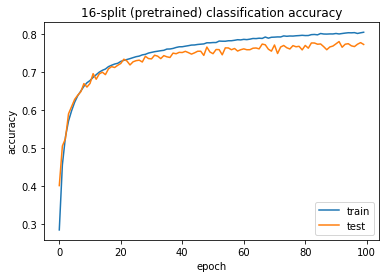

<Figure size 432x288 with 0 Axes>

In [3]:
model = MultiSplit(n_splits, latent_dim, io_shape)

model.encoder.load_weights('../weights/30_CE4x16_epoch50.h5')
for layer in model.encoder.layers:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=100, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('16-split (pretrained) classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.savefig('../img/33/CE4x16_epoch50.png')

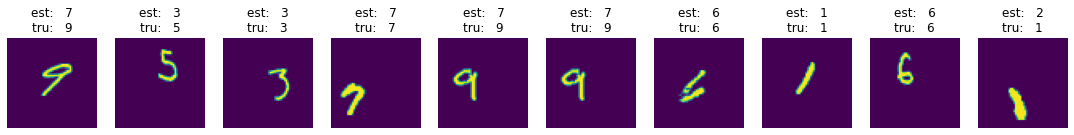

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random

n = 10
ints = [random.randint(0, len(x_test_split)) for _ in range(n)]
x_inputs = np.array([x_test_split[i] for i in ints], dtype='float32')
y_truths = [y_test[i] for i in ints]
x_truths = [x_test_augmented[i] for i in ints]

z = model.encode(x_inputs, training=False)
y = model.classify(z, training=False)
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est: {:3.0f}\ntru: {:3.0f}".format(np.argmax(y[i]), np.argmax(y_truths[i])))
    plt.imshow(x_truths[i].reshape(56,56))